## GMV backtest

This notebook follows the 06a-backtest example and implements GMV weighting in addition to equal-weighting.

In [48]:
from sqlalchemy import create_engine
!pip install pymssql
!pip install scikit-learn
import pymssql
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from cvxopt import matrix
from cvxopt.solvers import qp as Solver, options as SolverOptions
import statsmodels.api as sm
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt

model = LinearRegression()
qt = QuantileTransformer(output_distribution="normal")
poly = PolynomialFeatures(degree=2)
pipe = make_pipeline(poly, model)


[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
dfbase = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + dfbase
conn = create_engine(string).connect()

#### Get data

In [3]:
df = pd.read_sql(
    """
    select ticker, date, ret, roeq, bm, mom12m, mve
    from data
    where date>='2000-01'
    order by date, ticker
    """, 
    conn
)
df = df.dropna()
conn.close()


In [4]:
raw_data = df.copy()
raw_data = raw_data.reset_index()

In [5]:
features = ["roeq", "bm", "mom12m"]


In [6]:
# raw_data.set_index(['ticker','date']).xs('IBM', level='ticker', drop_level=False)
raw_data.set_index(['ticker','date']).xs('2000-01', level='date', drop_level=False)

,,index,ret,roeq,bm,mom12m,mve
ticker,date,,,,,,
AA,2000-01,1,-0.160392,0.039969,0.438760,0.783092,17.230341
AABC,2000-01,3,-0.029528,0.054207,1.107577,0.077586,9.194465
AAC,2000-01,4,0.056338,0.053986,1.893766,0.241379,12.072728
AACE,2000-01,5,-0.067568,0.049065,0.339860,0.095833,12.134491
AAG,2000-01,6,-0.100694,0.028019,0.703278,-0.294565,13.544615
...,...,...,...,...,...,...,...
ZOMX,2000-01,5709,-0.005525,0.094583,0.428749,3.557692,13.459701
ZONA,2000-01,5710,0.771429,-0.078612,0.249106,-0.715686,10.805451
ZQK,2000-01,5711,-0.217742,0.041841,0.397946,-0.243750,12.770872


### Estimate expanding window volatilities each month

In [7]:
WINDOW = 60

In [8]:
df = raw_data.set_index(['ticker','date']).sort_values(by=['ticker','date'])
df_wide = df.ret.unstack(level=0)
sds = df_wide.expanding(WINDOW).std()
sds = sds.stack()
sds = sds.swaplevel().sort_index()
sds.name = 'sd'
sds

ticker  date   
A       2007-03    0.128052
        2007-04    0.126989
        2007-05    0.126610
        2007-06    0.125585
        2007-07    0.124604
                     ...   
ZVXI    2021-11    0.273161
        2021-12    0.273161
        2022-01    0.273161
        2022-02    0.273161
        2022-03    0.273161
Name: sd, Length: 928365, dtype: float64

In [9]:
sds.xs('IBM',level='ticker', drop_level=False)

ticker  date   
IBM     2004-12    0.103784
        2005-01    0.103169
        2005-02    0.102328
        2005-03    0.101519
        2005-04    0.102848
                     ...   
        2021-11    0.071878
        2021-12    0.072231
        2022-01    0.072095
        2022-02    0.072109
        2022-03    0.072056
Name: sd, Length: 208, dtype: float64

#### Drop largest 500 stocks each month

In [10]:
df = raw_data.set_index(["date", "ticker"]).copy()

In [11]:
df["size_rnk"] = df.groupby("date").mve.rank(ascending=False)
df = df[df.size_rnk>500]

#### Transform features each month

In [12]:
def qt_df(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features] = df.groupby("date", group_keys=False)[features].apply(qt_df)

#### Transform target each month

In [13]:
def qt_ser(s):
    x = s.copy()
    x = x.to_numpy().reshape(-1, 1)
    x = qt.fit_transform(x).flatten()
    return pd.Series(x, index=s.index)

df["target"] = df.groupby("date", group_keys=False).ret.apply(qt_ser)

#### Train and predict in a loop

In [14]:
predictions = None

dates = ["2005-01", "2010-01", "2015-01", "2020-01", "3000-01"]
for train_date, end_date in zip(dates[:-1], dates[1:]):

    filter1 = df.index.get_level_values("date") < train_date
    filter2 = df.index.get_level_values("date") < end_date

    train = df[filter1]
    test = df[~filter1 & filter2]

    Xtrain = train[features]
    ytrain = train["target"]
    Xtest = test[features]

    pipe.fit(Xtrain, ytrain)
    pred = pipe.predict(Xtest)
    pred = pd.Series(pred, index=test.index)
    predictions = pd.concat((predictions, pred))

df["predict"] = predictions

#### Merge in volatilities

In [15]:
df = pd.merge(df, sds.swaplevel(), left_index=True, right_index=True)
df

index       ret      roeq        bm    mom12m        mve  \
date    ticker                                                               
2004-12 AACE     299202  0.111903  0.012259  0.686011  0.846174  12.790238   
        AAII     299204  0.051780  2.097185 -1.435987 -2.726759  11.388843   
        AAME     299205  0.033333 -0.282913  1.728346  0.298846  11.058055   
        AANB     299206  0.180442  0.505941 -0.247464  0.093628  10.909255   
        AAON     299207  0.009422  0.061443 -0.674471 -0.720448  12.193995   
...                 ...       ...       ...       ...       ...        ...   
2022-03 YELP    1022098  0.006492 -0.008022 -0.296959 -0.173110  14.721554   
        YORW    1022099  0.002229  0.344067 -0.624169  0.384817  13.285281   
        YTEN    1022100  0.261905 -1.262128  0.071652 -1.837949   9.928395   
        ZEUS    1022106  0.436683  1.467827  1.924874  0.666564  12.604142   
        ZUMZ    1022111 -0.141155  0.598113  0.083015  0.054865  13.757728   

                size_rnk    target   predict        sd  
date    ticker                                          
2004-12 AACE      2047.0  0.725076       NaN  0.116874  
        AAII      3170.0  0.222377       NaN  0.245369  
        AAME      3391.0  0.003373       NaN  0.121825  
        AANB      3491.0  1.162363       NaN  0.079512  
        AAON      2534.0 -0.342627       NaN  0.113154  
...                  ...       ...       ...       ...  
2022-03 YELP      1002.0  0.143844  0.036309  0.147324  
        YORW      1535.0  0.091432  0.056389  0.061721  
        YTEN      2311.0  1.597743 -0.169210  0.310849  
        ZEUS      1728.0  2.168410  0.130236  0.178060  
        ZUMZ      1370.0 -1.378972  0.072304  0.157737  

[430757 rows x 10 columns]

#### Lag volatility 

In [16]:
df['lag_sd'] = df.groupby(level=1).sd.shift(1)
df.xs('YELP',level='ticker', drop_level=False).head()

,,index,ret,roeq,bm,mom12m,mve,size_rnk,target,predict,sd,lag_sd
date,ticker,,,,,,,,,,,
2019-05,YELP,934302,-0.232901,-0.092168,-0.396406,-0.581662,15.005158,823.0,-1.145476,0.008860,0.147527,NaN
2019-06,YELP,937117,0.112268,0.442784,-0.395686,0.082686,14.680300,929.0,0.642551,0.052772,0.147019,0.147527
2019-07,YELP,939919,0.025453,0.441471,-0.400773,-0.179907,14.786702,918.0,0.356582,0.046187,0.145845,0.147019
2019-08,YELP,942694,-0.043937,0.447650,-0.402128,0.201198,14.811837,908.0,0.121159,0.054795,0.144772,0.145845
2019-09,YELP,945452,0.037004,-0.260449,-0.407563,-0.404116,14.682673,932.0,0.046494,0.007121,0.143694,0.144772


In [17]:
df['inverse_var'] = 1/(df.lag_sd**2)
df.xs('YELP',level='ticker', drop_level=False).head()

,,index,ret,roeq,bm,mom12m,mve,size_rnk,target,predict,sd,lag_sd,inverse_var
date,ticker,,,,,,,,,,,,
2019-05,YELP,934302,-0.232901,-0.092168,-0.396406,-0.581662,15.005158,823.0,-1.145476,0.008860,0.147527,NaN,NaN
2019-06,YELP,937117,0.112268,0.442784,-0.395686,0.082686,14.680300,929.0,0.642551,0.052772,0.147019,0.147527,45.946755
2019-07,YELP,939919,0.025453,0.441471,-0.400773,-0.179907,14.786702,918.0,0.356582,0.046187,0.145845,0.147019,46.264752
2019-08,YELP,942694,-0.043937,0.447650,-0.402128,0.201198,14.811837,908.0,0.121159,0.054795,0.144772,0.145845,47.012927
2019-09,YELP,945452,0.037004,-0.260449,-0.407563,-0.404116,14.682673,932.0,0.046494,0.007121,0.143694,0.144772,47.712104


#### Compute returns of portfolios of best and worst stocks

In [18]:
df = df.dropna(subset=["predict"])

numstocks = 100

df["rnk"] = df.groupby("date").predict.rank(method="first", ascending=False)
best = df[df.rnk<=numstocks]

df["rnk"] = df.groupby("date").predict.rank(method="first")
worst = df[df.rnk<=numstocks]

C:\Users\kpc2\AppData\Local\Temp\ipykernel_14008\1219390199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rnk"] = df.groupby("date").predict.rank(method="first", ascending=False)
C:\Users\kpc2\AppData\Local\Temp\ipykernel_14008\1219390199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rnk"] = df.groupby("date").predict.rank(method="first")


In [19]:
worst.head()

index       ret      roeq        bm    mom12m        mve  \
date    ticker                                                              
2005-01 AAII    303641 -0.178462  2.118992 -1.437618 -3.087117  11.439327   
        ABFI    303653 -0.466667 -2.880181  0.766901 -0.567059   8.370455   
        ACEC    303678  0.291667 -1.874422 -1.156635 -0.574120  10.407385   
        ACR     303687  0.064461 -2.059313 -1.859203  2.011144  12.608771   
        AICX    303773  0.090909 -2.127976 -1.084324 -2.235167   9.441300   

                size_rnk    target   predict        sd    lag_sd  inverse_var  \
date    ticker                                                                  
2005-01 AAII      3186.0 -1.292443 -0.176312  0.244647  0.245369    16.609714   
        ABFI      4236.0 -2.840673 -0.273414  0.249967  0.244860    16.678775   
        ACEC      3818.0  2.191251 -0.169931  0.347926  0.349213     8.200097   
        ACR       2237.0  1.112948 -0.267857  0.213641  0.215392    21.554619   
        AICX      4132.0  1.321948 -0.276635  0.365792  0.368810     7.351819   

                 rnk  
date    ticker        
2005-01 AAII    83.0  
        ABFI    12.0  
        ACEC    91.0  
        ACR     16.0  
        AICX    11.0

#### Equal-weighted returns

In [20]:
best_rets  = best.groupby("date").ret.mean()
worst_rets = worst.groupby("date").ret.mean()
rets = pd.concat((best_rets, worst_rets), axis=1)
rets.columns = ["best", "worst"]
rets.head()
# rets.to_csv("files/rets.csv")


,best,worst
date,,
2005-01,-0.005356,-0.081827
2005-02,0.041530,-0.074315
2005-03,-0.048466,-0.089032
2005-04,-0.061057,-0.105959
2005-05,0.051723,0.043296


#### Risk-parity returns

In [21]:
best

index       ret      roeq        bm    mom12m        mve  \
date    ticker                                                               
2005-01 ABL      303659  0.052632  1.182907  1.628030  1.130569  10.577421   
        ACAS     303672  0.019490  1.338645  0.419595  0.286749  14.900129   
        AGII     303755  0.013725  0.389729  1.641080  0.577761  13.280026   
        ALDA     303799 -0.072787  1.483048  1.812573  2.518106  11.266855   
        ALG      303804 -0.033137  0.426933  1.259061  0.823644  12.485536   
...                 ...       ...       ...       ...       ...        ...   
2022-03 VIA     1021967 -0.260987  1.335621 -0.000832  0.692222  12.069410   
        VIRC    1021970 -0.006645  1.091610  1.286850 -0.051664  10.788639   
        WSBF    1022056 -0.010235  0.660527  0.661027  0.535450  13.067852   
        X       1022079  0.386990  1.981783  0.925956  0.871628  15.775596   
        ZEUS    1022106  0.436683  1.467827  1.924874  0.666564  12.604142   

                size_rnk    target   predict        sd    lag_sd  inverse_var  \
date    ticker                                                                  
2005-01 ABL       3731.0  1.008471  0.170241  0.096840  0.097448   105.306743   
        ACAS       626.0  0.695581  0.116341  0.079592  0.080264   155.225159   
        AGII      1721.0  0.631787  0.127166  0.104596  0.105478    89.882681   
        ALDA      3301.0 -0.478855  0.150051  0.193612  0.194712    26.376371   
        ALG       2336.0 -0.015578  0.116249  0.069438  0.069686   205.926709   
...                  ...       ...       ...       ...       ...          ...   
2022-03 VIA       1858.0 -2.049083  0.087820  0.093421  0.090719   121.508051   
        VIRC      2191.0 -0.024321  0.103784  0.128988  0.129351    59.767118   
        WSBF      1602.0 -0.063724  0.090299  0.130029  0.130415    58.795838   
        X          586.0  1.985105  0.109824  0.177038  0.175901    32.319572   
        ZEUS      1728.0  2.168410  0.130236  0.178060  0.176567    32.076151   

                  rnk  
date    ticker         
2005-01 ABL       6.0  
        ACAS     93.0  
        AGII     63.0  
        ALDA     25.0  
        ALG      94.0  
...               ...  
2022-03 VIA     100.0  
        VIRC     18.0  
        WSBF     75.0  
        X        12.0  
        ZEUS      3.0  

[20700 rows x 13 columns]

In [22]:
sum_inverse_var = best.groupby('date').inverse_var.sum()
sum_inverse_var.name = 'sum_inverse_var'
sum_inverse_var

date
2005-01    5611.806555
2005-02    6029.050128
2005-03    5454.688393
2005-04    5507.294438
2005-05    5981.954414
              ...     
2021-11    9222.628044
2021-12    7705.782159
2022-01    7348.069793
2022-02    8236.535117
2022-03    7600.272952
Name: sum_inverse_var, Length: 207, dtype: float64

In [23]:
best = best.reset_index().merge(sum_inverse_var,left_on='date',right_on='date')
best.head()

,date,ticker,index,ret,roeq,bm,mom12m,mve,size_rnk,target,predict,sd,lag_sd,inverse_var,rnk,sum_inverse_var
0,2005-01,ABL,303659,0.052632,1.182907,1.628030,1.130569,10.577421,3731.0,1.008471,0.170241,0.096840,0.097448,105.306743,6.0,5611.806555
1,2005-01,ACAS,303672,0.019490,1.338645,0.419595,0.286749,14.900129,626.0,0.695581,0.116341,0.079592,0.080264,155.225159,93.0,5611.806555
2,2005-01,AGII,303755,0.013725,0.389729,1.641080,0.577761,13.280026,1721.0,0.631787,0.127166,0.104596,0.105478,89.882681,63.0,5611.806555
3,2005-01,ALDA,303799,-0.072787,1.483048,1.812573,2.518106,11.266855,3301.0,-0.478855,0.150051,0.193612,0.194712,26.376371,25.0,5611.806555
4,2005-01,ALG,303804,-0.033137,0.426933,1.259061,0.823644,12.485536,2336.0,-0.015578,0.116249,0.069438,0.069686,205.926709,94.0,5611.806555


In [24]:
best['wgt'] = best.inverse_var/best.sum_inverse_var
best['wgt_x_ret'] = best.wgt * best.ret
best_rets = best.groupby("date").wgt_x_ret.sum()
best_rets.head()

date
2005-01    0.009367
2005-02    0.045342
2005-03   -0.043387
2005-04   -0.044839
2005-05    0.053237
Name: wgt_x_ret, dtype: float64

Alternative with more concise coding

In [25]:
best_rets2 = best.groupby("date").apply(lambda d: (d.ret*d.inverse_var).sum()/d.inverse_var.sum())
best_rets2.head()

date
2005-01    0.009367
2005-02    0.045342
2005-03   -0.043387
2005-04   -0.044839
2005-05    0.053237
dtype: float64

Same for worst

In [26]:
sum_inverse_var = worst.groupby('date').inverse_var.sum()
sum_inverse_var.name = 'sum_inverse_var'
worst = worst.reset_index().merge(sum_inverse_var,left_on='date',right_on='date')
worst['wgt'] = worst.inverse_var/worst.sum_inverse_var
worst['wgt_x_ret'] = worst.wgt * worst.ret
worst_rets = worst.groupby("date").wgt_x_ret.sum()

In [27]:
rets_risk_parity = pd.concat((best_rets, worst_rets), axis=1)
rets_risk_parity.columns = ["best", "worst"]
rets_risk_parity.head()

,best,worst
date,,
2005-01,0.009367,-0.069581
2005-02,0.045342,-0.051452
2005-03,-0.043387,-0.062486
2005-04,-0.044839,-0.071012
2005-05,0.053237,0.039750


## GMV (covariances based on market model)

In [30]:
# Pull MKTRF and RF
ff3 = pdr('F-F_Research_Data_Factors','famafrench', start=1900)[0]/100
est_mkt_std = ff3['Mkt-RF'].expanding(60).std()

x = raw_data.set_index(pd.to_datetime(raw_data.date, infer_datetime_format=True).dt.to_period('M'))
merged = pd.merge(x, ff3, how='left',left_index=True,right_index=True)
merged['xret'] = merged.ret - merged['RF']
cols = merged.columns
merged = merged.reset_index()
merged.columns = ['mdate'] +cols.to_list()
merged = merged.set_index(['mdate','ticker'])


In [31]:
# Auxiliary functions
def estimate_betas(d,tickers,mdate):
    df_beta = pd.DataFrame(index=tickers, columns=['alpha','beta'],dtype=float)
    for ticker in tickers:
        subset = d.xs(ticker,level=1).loc[:mdate].iloc[:-1]
        y =subset.xret
        X = sm.add_constant(subset['Mkt-RF'])
        mm = sm.OLS(y, X, missing='drop').fit()
        df_beta.loc[ticker] = mm.params.values
    return df_beta['beta'].values

def is_pos_def(x):
    if np.all(np.linalg.eigvals(x) > 0):
        return 'True'
    else:
        return 'False'
    
def ls_constrained_gmv(n, cov, max_wgt):
    '''
    n: assets on each side of portfolio (n longs and n shorts; longs on top)
    '''
    Q = matrix(cov, tc="d")
    p = matrix(np.zeros(2*n), (2*n, 1), tc="d")
    # Constraint: (1) long-only for first n (2) short-only for remaining n (3) max long position = 0.05 (4) min short position = -0.05
    cons1 = np.hstack((-np.identity(n),np.zeros((n,n))))
    cons2 = np.hstack((np.zeros((n,n)),np.identity(n)))
    cons3 = -cons1
    cons4 = -cons2
    G = matrix(np.vstack((cons1,cons2,cons3,cons4)), tc="d")
    h = matrix(np.vstack((np.zeros(2*n),max_wgt*np.ones(2*n))).reshape(-1), (4*n, 1), tc="d")        
    # Constraint: (1) fully-invested portfolio (2) longs sum to 1.3 (3) shorts sum to -0.3
    cons1 = np.ones(2*n)
    cons2 = np.hstack((np.ones(n),np.zeros(n)))
    A = matrix(np.vstack((cons1,cons2)), (2, 2*n), tc="d")
    b = matrix([1, 1.3], (2, 1), tc="d")    
    sol = Solver(Q, p, G, h, A, b)
    wgts = np.array(sol["x"]).flatten() if sol["status"] == "optimal" else np.array(n * [np.nan])
    return wgts   
SolverOptions['show_progress'] = False 

In [ ]:
mdate_list = best.date.unique()
mdate_list

rets_gmv = pd.DataFrame(dtype=float,index=best_rets.index,columns = ['best','worst','ls'])

for MDATE in mdate_list:
    print(MDATE)

    # Extract securities selected that month
    b = best.set_index(['date','ticker']).xs(MDATE,level=0)
    w = worst.set_index(['date','ticker']).xs(MDATE,level=0)
    all= pd.concat([b,w])
    ticker_list = all.index.to_list()

    # Calculate expanding window betas for these tickers
    mkt_std = est_mkt_std.loc[:MDATE][-1]  # Pull last month's estimated market std dev
    betas = estimate_betas(merged,ticker_list,MDATE)
    betas = 0.67*betas+0.33               # Shrink betas towards 1
    sds_mkt_model = betas * mkt_std
    # SDS = all.lag_sd.fillna(value=all.lag_sd.mean()).values
    SDS = np.where(all.lag_sd.isnull(), 2*sds_mkt_model, all.lag_sd)
    COV = np.diag(SDS) @ np.identity(200) @ np.diag(SDS)
    for j, ticker in enumerate(ticker_list):
        for k in range(j+1,200):
            COV[j, k] = COV[k, j] = betas[j] * betas[k] * (mkt_std**2) 

    print(f'Positive definite?: {is_pos_def(COV)}')

    # Calculate constrained GMV portfolio and portfolio returns
    if is_pos_def(COV)=='True':
        wgts_gmv_cons = ls_constrained_gmv(100,COV,0.03)
    else:
        # Revert to equal-weighting if covariance matrix is not positive definite
        wgts_gmv_cons = np.hstack((1.3*np.ones(100)/100, -0.3*np.ones(100)/100))
    rets_gmv.loc[MDATE,'ls'] = all.ret @ wgts_gmv_cons
    rets_gmv.loc[MDATE,'best'] = all.ret[:100] @ wgts_gmv_cons[:100] / wgts_gmv_cons[:100].sum()
    rets_gmv.loc[MDATE,'worst'] = all.ret[100:] @ wgts_gmv_cons[100:] / wgts_gmv_cons[100:].sum()

In [33]:
print(f'Equal-weighted')
print(f'Best: average return:\t {rets.best.mean(): .4f}')
print(f'Best: SD(return):\t {rets.best.std(): .4f}')
print(f'Worst: average return:\t {rets.worst.mean(): .4f}')
print(f'Worst: SD(return):\t {rets.worst.std(): .4f}')

print(f'\nRisk parity')
print(f'Best: average return:\t {rets_risk_parity.best.mean(): .4f}')
print(f'Best: SD(return):\t {rets_risk_parity.best.std(): .4f}')
print(f'Worst: average return:\t {rets_risk_parity.worst.mean(): .4f}')
print(f'Worst: SD(return):\t {rets_risk_parity.worst.std(): .4f}')

print(f'\nGMV')
print(f'Best: average return:\t {rets_gmv.best.mean(): .4f}')
print(f'Best: SD(return):\t {rets_gmv.best.std(): .4f}')
print(f'Worst: average return:\t {rets_gmv.worst.mean(): .4f}')
print(f'Worst: SD(return):\t {rets_gmv.worst.std(): .4f}')



Equal-weighted
Best: average return:	  0.0134
Best: SD(return):	  0.0552
Worst: average return:	  0.0134
Worst: SD(return):	  0.1142

Risk parity
Best: average return:	  0.0118
Best: SD(return):	  0.0453
Worst: average return:	  0.0144
Worst: SD(return):	  0.1117

GMV
Best: average return:	  0.0110
Best: SD(return):	  0.0437
Worst: average return:	  0.0169
Worst: SD(return):	  0.1369


# Performance evaluation

In [37]:
rets.index = pd.to_datetime(rets.index).to_period("M")
rets["mkt"] = ff3["Mkt-RF"] + ff3["RF"]
rets["ls"] = 1.3*rets["best"] - 0.3*rets["worst"]
rets["rf"] = ff3["RF"]

In [38]:
rets_risk_parity.index = pd.to_datetime(rets_risk_parity.index).to_period("M")
rets_risk_parity["mkt"] = ff3["Mkt-RF"] + ff3["RF"]
rets_risk_parity["ls"] = 1.3*rets_risk_parity["best"] - 0.3*rets_risk_parity["worst"]
rets_risk_parity["rf"] = ff3["RF"]

In [39]:
rets_gmv.index = pd.to_datetime(rets_gmv.index).to_period("M")
rets_gmv["mkt"] = ff3["Mkt-RF"] + ff3["RF"]
rets_gmv["ls2"] = 1.3*rets_gmv["best"] - 0.3*rets_gmv["worst"]
rets_gmv["rf"] = ff3["RF"]

Accumulations

<AxesSubplot:xlabel='date'>

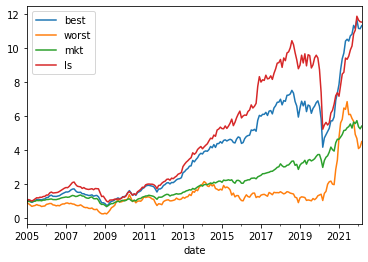

In [41]:
(1+rets[["best", "worst", "mkt", "ls"]]).cumprod().plot()

<AxesSubplot:xlabel='date'>

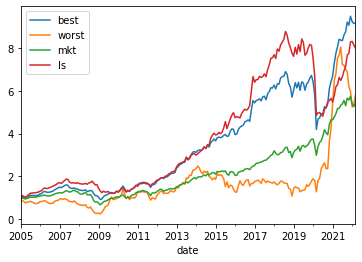

In [42]:
(1+rets_risk_parity[["best", "worst", "mkt", "ls"]]).cumprod().plot()

<AxesSubplot:xlabel='date'>

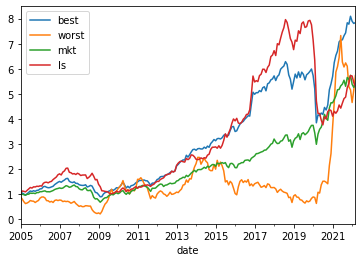

In [43]:
(1+rets_gmv[["best", "worst", "mkt", "ls"]]).cumprod().plot()

Excess returns and Sharpe ratios

In [44]:
xrets = rets[["best", "worst", "mkt", "ls"]].subtract(rets.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes.round(4)

best     0.7764
worst    0.3780
mkt      0.6513
ls       0.8078
dtype: float64

In [45]:
xrets = rets_risk_parity[["best", "worst", "mkt", "ls"]].subtract(rets_risk_parity.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes.round(4)

best     0.8294
worst    0.4152
mkt      0.6513
ls       0.8076
dtype: float64

In [46]:
xrets = rets_gmv[["best", "worst", "mkt", "ls"]].subtract(rets_gmv.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes.round(4)

best     0.7930
worst    0.4022
mkt      0.6513
ls       0.6104
dtype: float64

130/30 drawdowns

Text(0, 0.5, ' % Drawdown')

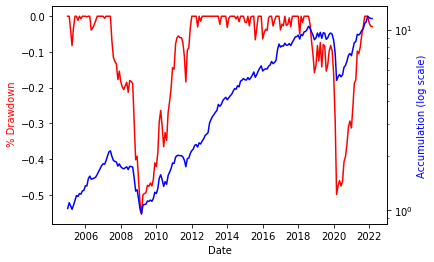

In [49]:
ls = (1+rets.ls).cumprod()
lsmax = ls.expanding().max()
drawdown = ls/lsmax - 1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.plot(rets.index.to_timestamp(), ls, 'b-')
ax1.plot(rets.index.to_timestamp(), drawdown, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Accumulation (log scale)', color='b')
ax1.set_ylabel(' % Drawdown', color='r')

Text(0, 0.5, ' % Drawdown')

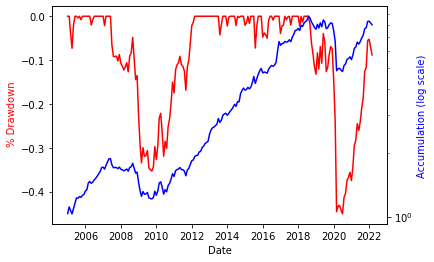

In [50]:
ls = (1+rets_risk_parity.ls).cumprod()
lsmax = ls.expanding().max()
drawdown = ls/lsmax - 1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.plot(rets_risk_parity.index.to_timestamp(), ls, 'b-')
ax1.plot(rets_risk_parity.index.to_timestamp(), drawdown, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Accumulation (log scale)', color='b')
ax1.set_ylabel(' % Drawdown', color='r')

Text(0, 0.5, ' % Drawdown')

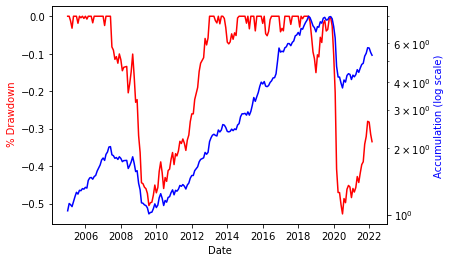

In [51]:
ls = (1+rets_gmv.ls).cumprod()
lsmax = ls.expanding().max()
drawdown = ls/lsmax - 1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.plot(rets_gmv.index.to_timestamp(), ls, 'b-')
ax1.plot(rets_gmv.index.to_timestamp(), drawdown, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Accumulation (log scale)', color='b')
ax1.set_ylabel(' % Drawdown', color='r')